## Verifying multiple fairness definitions in group fairness for multiple classification algorithms using Justicia

In this tutorial, we verify different group fairness definitions such as disparate impact, statistical parity, and equalized odds using SSAT-based verifier Justicia. We verify them on different classification models such as linear models and decision trees. 


In [1]:
# standard library
import sklearn.metrics
from sklearn.model_selection import train_test_split
from pyrulelearn.imli import imli
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn import tree
import seaborn as sns
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
from IPython.display import Markdown, display
import sys


# From this framework
import justicia.utils
from justicia.metrics import Metric

# data
sys.path.append("..")
from data.objects.adult import Adult
from data.objects.titanic import Titanic

### Prepare a dataset

In [2]:
verbose = False
dataset = Adult(verbose=verbose, config=0) # config defines configuration for sensitive groups
df = dataset.get_df()
# get X,y
X = df.drop(['target'], axis=1)
y = df['target']
display(Markdown("#### Sensitive attributes"))
print(dataset.known_sensitive_attributes)
display(Markdown("#### Feature matrix"))
print("Before one hot encoding")
X.head()


#### Sensitive attributes

['race', 'sex']


#### Feature matrix

Before one hot encoding


,race,sex,age,education-num,capital-gain,capital-loss,hours-per-week
0,White,Male,0.301370,0.800000,0.02174,0.0,0.397959
1,White,Male,0.452055,0.800000,0.00000,0.0,0.122449
2,White,Male,0.287671,0.533333,0.00000,0.0,0.397959
3,Black,Male,0.493151,0.400000,0.00000,0.0,0.397959
4,Black,Female,0.150685,0.800000,0.00000,0.0,0.397959


In [3]:
# one-hot encoding for categorical features (this takes care of Label encoding automatically)
X = justicia.utils.get_one_hot_encoded_df(X,dataset.categorical_attributes)
print("After->")    
X 

After->


,sex,age,education-num,capital-gain,capital-loss,hours-per-week,race_Amer-Indian-Eskimo,race_Asian-Pac-Islander,race_Black,race_Other,race_White
0,0,0.301370,0.800000,0.021740,0.0,0.397959,0,0,0,0,1
1,0,0.452055,0.800000,0.000000,0.0,0.122449,0,0,0,0,1
2,0,0.287671,0.533333,0.000000,0.0,0.397959,0,0,0,0,1
3,0,0.493151,0.400000,0.000000,0.0,0.397959,0,0,1,0,0
4,1,0.150685,0.800000,0.000000,0.0,0.397959,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...
32556,1,0.136986,0.733333,0.000000,0.0,0.377551,0,0,0,0,1
32557,0,0.315068,0.533333,0.000000,0.0,0.397959,0,0,0,0,1
32558,1,0.561644,0.533333,0.000000,0.0,0.397959,0,0,0,0,1
32559,0,0.068493,0.533333,0.000000,0.0,0.193878,0,0,0,0,1


### Train a classifier

In [4]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, shuffle = True, random_state=2) # 70% training and 30% test

clf = LogisticRegression(class_weight='balanced', solver='liblinear', random_state=0)
# clf = tree.DecisionTreeClassifier(max_depth=5)
# clf = SVC(kernel="linear")


clf.fit(X_train.values, y_train.values)
print("\nTrain Accuracy:", sklearn.metrics.accuracy_score(clf.predict(X_train.values),y_train.values))
print("Test Accuracy:", sklearn.metrics.accuracy_score(clf.predict(X_test.values),y_test.values))        


Train Accuracy: 0.764946764946765
Test Accuracy: 0.7675775253300583


### Compute disparate impact and statistical parity using Justicia

Let $ A $ denote sensitive attributes, $ Y $ be true class label, and $ \hat{Y} $ be predicted class label. Disparate impact and statistical parity has following definitions.


$\begin{align*}
    &\text{Disparate Impact} \triangleq \frac{\min_\limits{\mathbf{a} \in A} \Pr[\hat{Y} = 1 | A = \mathbf{a}]}{\max_\limits{\mathbf{a} \in A} \Pr[\hat{Y} = 1 | A = \mathbf{a}]} \\ 
    &\text{Statistical Parity} \triangleq \max_\limits{\mathbf{a} \in A} \Pr[\hat{Y} = 1 | A = \mathbf{a}] - \min_\limits{\mathbf{a} \in A} \Pr[\hat{Y} = 1 | A = \mathbf{a}]
    \end{align*}
$

Hence, disparate impact is computed as the ratio between the most favored sensitive group and the least favored sensitive group based on PPV of the classifier. For statistical parity, we consider their difference.



In [5]:
metric = Metric(model=clf, data=X_test, sensitive_attributes=dataset.known_sensitive_attributes, verbose=False, encoding="best-correlated")
metric.compute()
print("Sensitive attributes", metric.given_sensitive_attributes)
print("Disparate Impact:", metric.disparate_impact_ratio)
print("Statistical Parity:", metric.statistical_parity_difference)
print("Time taken", metric.time_taken, "seconds")

Sensitive attributes ['race', 'sex']
Disparate Impact: 0.6044797508650545
Statistical Parity: 0.18962418850272234
Time taken 20.451167106628418 seconds


We now show how disparate impact and statistical parity have been computed vividly. For that, we look into the positive predictive value (PPV) of the classifier for different sensitive groups.

### Detailed analysis based the positive predictive value (PPV) for individual sensitive groups

#### Most Favored group

race_Asian-Pac-Islander == 1, sex != 1


#### Least Favored group

race_Amer-Indian-Eskimo == 1, sex == 1


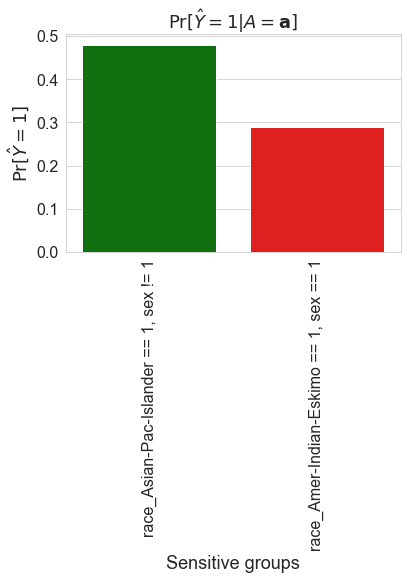

<Figure size 432x288 with 0 Axes>

In [6]:
groups = [(", ").join([" ".join([each_sensitive_attribute[0], each_sensitive_attribute[1][0], str(each_sensitive_attribute[1][1])])  for each_sensitive_attribute in group_info[0]]) for group_info in metric.sensitive_group_statistics]
PPVs = np.array([group_info[1] for group_info in metric.sensitive_group_statistics])

assert metric.disparate_impact_ratio == float(PPVs.min()/PPVs.max())
assert metric.statistical_parity_difference == PPVs.max() - PPVs.min()
display(Markdown("#### Most Favored group"))
print((", ").join([" ".join([each_sensitive_attribute[0], each_sensitive_attribute[1][0], str(each_sensitive_attribute[1][1])]) for each_sensitive_attribute in list(metric.most_favored_group.items())]))
display(Markdown("#### Least Favored group"))
print((", ").join([" ".join([each_sensitive_attribute[0], each_sensitive_attribute[1][0], str(each_sensitive_attribute[1][1])]) for each_sensitive_attribute in list(metric.least_favored_group.items())]))

customize_color = {}
for idx, PPV in enumerate(PPVs):
    customize_color[groups[idx]] = "red" if PPV == PPVs.min() else ("green" if PPV ==PPVs.max() else "gray")
fontsize = 22
labelsize = 18

sns.set_style("whitegrid", {'axes.grid' : True})
sns.barplot(x=groups, y=PPVs, palette=customize_color)
plt.xticks(fontsize=labelsize-2, rotation=90)
plt.yticks(fontsize=labelsize-2)
plt.ylabel(r"$\Pr[\hat{Y} = 1]$", fontsize=labelsize)
plt.xlabel("Sensitive groups", fontsize=labelsize)
plt.title(r"$\Pr[\hat{Y} = 1 | A=\mathbf{a}]$", fontsize=labelsize)
plt.show()
plt.clf()

### Equalized odds computation using Justicia
The computation of equalized odds is similar to statistical parity but by acknowledging for different class label.

By definition, we compute statistical parity for different classes.

$\begin{align*} 
&\max_\limits{\mathbf{a} \in A} \Pr[\hat{Y} = 1 | A = \mathbf{a}, Y = 1] - \min_\limits{\mathbf{a} \in A} \Pr[\hat{Y} = 1 | A = \mathbf{a}, Y = 1]\\ 
&\max_\limits{\mathbf{a} \in A} \Pr[\hat{Y} = 1 | A = \mathbf{a}, Y = 0] - \min_\limits{\mathbf{a} \in A} \Pr[\hat{Y} = 1 | A = \mathbf{a}, Y = 0]
\end{align*}
$

Similar computation can be applied for disparate impact, but for $Y = 1$ and $Y = 0$ classes.





In [7]:
metric_eqo = Metric(model=clf, data=X_test, sensitive_attributes=dataset.known_sensitive_attributes, verbose=False, encoding="best-correlated")
metric_eqo.compute_eqo(y_test)
display(Markdown("#### In results, the first entry is for $Y=1$ class and the second entry is for $Y=0$ class"))
print("Disparate Impact:", metric_eqo.disparate_impact_ratio)
print("Statistical Parity:", metric_eqo.statistical_parity_difference)
print("Time taken", metric_eqo.time_taken, "seconds")

#### In results, the first entry is for $Y=1$ class and the second entry is for $Y=0$ class

Disparate Impact: [0.5738564822003906, 0.5906606176336412]
Statistical Parity: [0.26610841416023884, 0.15786280131779143]
Time taken 33.640486001968384 seconds


### Detailed analysis of equalized odds for individual sensitive compound groups

### Results for $Y = 1$

Most Favored group: race_Asian-Pac-Islander == 1, sex != 1
Least Favored group: race_Amer-Indian-Eskimo == 1, sex == 1


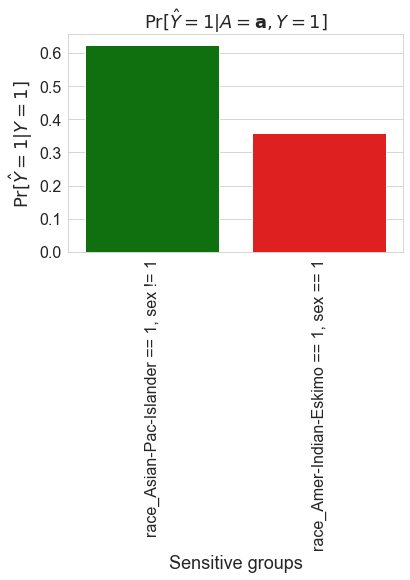

### Results for $Y = 0$

Most Favored group: race_White == 1, sex != 1
Least Favored group: race_Other == 1, sex == 1


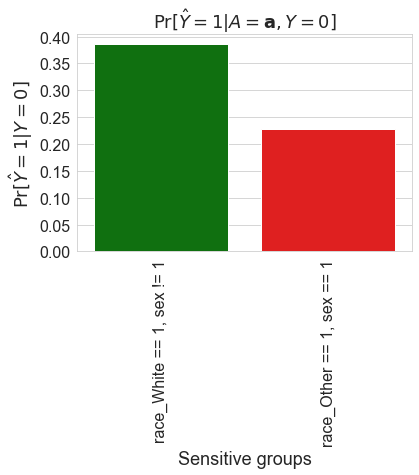

<Figure size 432x288 with 0 Axes>

In [8]:
groups_y_1 = [(", ").join([" ".join([each_sensitive_attribute[0], each_sensitive_attribute[1][0], str(each_sensitive_attribute[1][1])])  for each_sensitive_attribute in group_info[0]]) for group_info in metric_eqo.sensitive_group_statistics[0]]
PPVs_y_1 = np.array([group_info[1] for group_info in metric_eqo.sensitive_group_statistics[0]])

customize_color = {}
for idx, PPV in enumerate(PPVs_y_1):
    customize_color[groups_y_1[idx]] = "red" if PPV == PPVs_y_1.min() else ("green" if PPV ==PPVs_y_1.max() else "gray")

assert metric_eqo.disparate_impact_ratio[0] == float(PPVs_y_1.min()/PPVs_y_1.max())
assert metric_eqo.statistical_parity_difference[0] == PPVs_y_1.max() - PPVs_y_1.min()
display(Markdown("### Results for $Y = 1$"))
print("Most Favored group:", (", ").join([" ".join([each_sensitive_attribute[0], each_sensitive_attribute[1][0], str(each_sensitive_attribute[1][1])])    for each_sensitive_attribute in list(metric_eqo.most_favored_group[0].items())]))
print("Least Favored group:", (", ").join([" ".join([each_sensitive_attribute[0], each_sensitive_attribute[1][0], str(each_sensitive_attribute[1][1])])    for each_sensitive_attribute in list(metric_eqo.least_favored_group[0].items())]))


sns.set_style("whitegrid", {'axes.grid' : True})
sns.barplot(x=groups_y_1, y=PPVs_y_1, palette=customize_color)
plt.xticks(fontsize=labelsize-2, rotation=90)
plt.yticks(fontsize=labelsize-2)
plt.ylabel(r"$\Pr[\hat{Y} = 1 | Y = 1]$", fontsize=labelsize)
plt.xlabel("Sensitive groups", fontsize=labelsize)
plt.title(r"$\Pr[\hat{Y} = 1 | A=\mathbf{a}, Y = 1]$", fontsize=labelsize)
plt.show()
plt.clf()

groups_y_0 = [(", ").join([" ".join([each_sensitive_attribute[0], each_sensitive_attribute[1][0], str(each_sensitive_attribute[1][1])])  for each_sensitive_attribute in group_info[0]]) for group_info in metric_eqo.sensitive_group_statistics[1]]
PPVs_y_0 = np.array([group_info[1] for group_info in metric_eqo.sensitive_group_statistics[1]])

customize_color = {}
for idx, PPV in enumerate(PPVs_y_0):
    customize_color[groups_y_0[idx]] = "red" if PPV == PPVs_y_0.min() else ("green" if PPV ==PPVs_y_0.max() else "gray")

assert metric_eqo.disparate_impact_ratio[1] == float(PPVs_y_0.min()/PPVs_y_0.max())
assert metric_eqo.statistical_parity_difference[1] == PPVs_y_0.max() - PPVs_y_0.min()
display(Markdown("### Results for $Y = 0$"))
print("Most Favored group:", (", ").join([" ".join([each_sensitive_attribute[0], each_sensitive_attribute[1][0], str(each_sensitive_attribute[1][1])])    for each_sensitive_attribute in list(metric_eqo.most_favored_group[1].items())]))
print("Least Favored group:", (", ").join([" ".join([each_sensitive_attribute[0], each_sensitive_attribute[1][0], str(each_sensitive_attribute[1][1])])    for each_sensitive_attribute in list(metric_eqo.least_favored_group[1].items())]))


sns.set_style("whitegrid", {'axes.grid' : True})
sns.barplot(x=groups_y_0, y=PPVs_y_0, palette=customize_color)
plt.xticks(fontsize=labelsize-2, rotation=90)
plt.yticks(fontsize=labelsize-2)
plt.ylabel(r"$\Pr[\hat{Y} = 1 | Y = 0]$", fontsize=labelsize)
plt.xlabel("Sensitive groups", fontsize=labelsize)
plt.title(r"$\Pr[\hat{Y} = 1 | A=\mathbf{a}, Y = 0]$", fontsize=labelsize)
plt.show()
plt.clf()

